# L'envers du décode

Article: 

## Pre-requis

Si vous souhaitez utiliser le même dépôt que dans l'article, vous pouvez cloner le projet Spring Boot avec la commande :

```bash
git clone https://github.com/spring-projects/spring-boot spring-boot
git checkout 05e4262a25
```

Mais le plus fun serait que vous exécutiez les analyses sur l'un de vos dépôts !

## Librairies utilisées

- pandas
- matplotlib
- networkx
- scipy

In [3]:
# Quelques variables qui centralisent les infos communes
git_repo = './spring-boot'
git_log_path = './output/spring_boot_log.csv'

## Extraction des logs git

In [6]:
from git import git_log_to_csv
git_log_to_csv(git_repo, git_log_path)

## Import des données avec pandas

In [4]:
import pandas as pd

df = pd.read_csv(git_log_path, on_bad_lines='skip')
df

,commit,author,date,file,added,removed
0,52b7b3cc46d8e80eceebb8eb0002affe7ccf600d,Stéphane Nicoll,2024-10-22T11:29:55+02:00,.github/ISSUE_TEMPLATE/config.yml,2,2
1,e2d375591108599bd3f60b62a33a580be8285621,Dmytro Nosan,2024-10-17T17:51:55+03:00,.github/ISSUE_TEMPLATE/config.yml,5,0
2,e2d375591108599bd3f60b62a33a580be8285621,Dmytro Nosan,2024-10-17T17:51:55+03:00,.github/{ISSUE_TEMPLATE.md => ISSUE_TEMPLATE/i...,8,0
3,8d62c023dddc32ec6d524d4e8f2f92baf71e61c2,Stéphane Nicoll,2024-10-07T07:47:35+02:00,.github/actions/await-http-resource/action.yml,1,1
4,682a5b27aaa6586e3adabd6af16248f190d9c2d0,Andy Wilkinson,2024-07-22T09:05:30+01:00,.github/actions/await-http-resource/action.yml,20,0
...,...,...,...,...,...,...
11438,43cd24102fed1aee0c78ea0931027c8773634bc3,Andy Wilkinson,2024-06-19T19:27:10-07:00,src/checkstyle/checkstyle-suppressions.xml,3,2
11439,a8381e7cbd2688e89f1cce060fea63d50e3de978,Andy Wilkinson,2025-04-01T10:30:58+01:00,src/checkstyle/checkstyle.xml,1,1
11440,7433b93769c060f9dd054bf455e305ce979c0869,Phillip Webb,2025-02-06T13:11:58-08:00,src/checkstyle/import-control.xml,1,0
11441,b7979cf443a68c00e2ca45267b0a7a80518d0ac5,Stéphane Nicoll,2024-10-18T08:07:45+02:00,src/checkstyle/import-control.xml,1,0


### Le top 10 des fichiers les plus révisés

In [5]:
from IPython.display import HTML

top_10 = (
    df.groupby('file')['commit']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name='revisions')
)

HTML(top_10.to_html(escape=False))

,file,revisions
0,spring-boot-project/spring-boot-dependencies/build.gradle,1466
1,gradle.properties,186
2,spring-boot-project/spring-boot-docs/src/docs/antora/modules/reference/pages/features/logging.adoc,32
3,.github/workflows/release.yml,30
4,spring-boot-project/spring-boot-actuator-autoconfigure/build.gradle,24
5,spring-boot-project/spring-boot-docs/src/docs/antora/modules/reference/pages/actuator/endpoints.adoc,24
6,.github/actions/prepare-gradle-build/action.yml,24
7,spring-boot-project/spring-boot-tools/spring-boot-test-support-docker/src/main/java/org/springframework/boot/testsupport/container/TestImage.java,24
8,spring-boot-project/spring-boot/src/main/resources/META-INF/additional-spring-configuration-metadata.json,23
9,.github/workflows/ci.yml,23


#### Visualisation

<Figure size 1000x600 with 0 Axes>

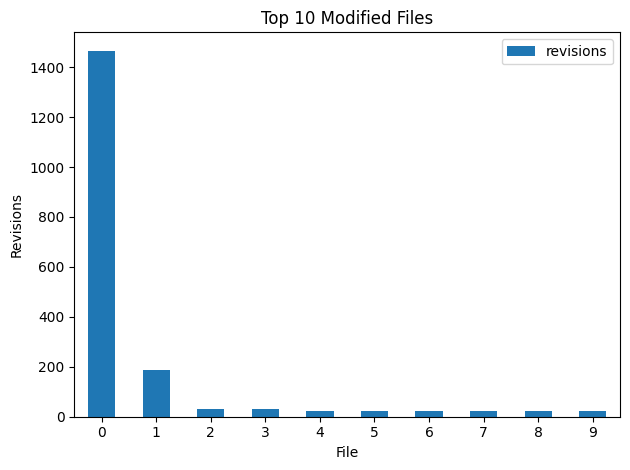

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_10.plot(kind='bar')
plt.title(f"Top 10 Modified Files")
plt.xlabel("File")
plt.ylabel("Revisions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Construction du graphe

In [8]:
import networkx as nx

G = nx.Graph() # création d'un graphe vide

# Regrouper par auteur et fichier pour compter combien de fois chaque auteur a modifié chaque fichier
grouped = df.groupby(['author', 'file'])['commit'].nunique().reset_index(name='revisions')

for _, row in grouped.iterrows():
  # Ajouter un nœud pour l’auteur (si non existant)
  G.add_node(row['author'], type='author')

  # Ajouter un nœud pour le fichier (si non existant)
  G.add_node(row['file'], type='file')

  # Créer un lien entre l’auteur et le fichier, pondéré par le nombre de révisions
  G.add_edge(row['author'], row['file'], weight=row['revisions'])

In [9]:
print(G)

Graph with 4676 nodes and 6851 edges


### Visualisation du graphe

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(G, node_size=30, edge_alpha=0.1, figsize=(12, 12)):
    plt.figure(figsize=figsize)
    pos = nx.kamada_kawai_layout(G)

    # Sépare les auteurs des fichiers
    authors = [n for n, d in G.nodes(data=True) if d.get('type') == 'author']
    files = [n for n, d in G.nodes(data=True) if d.get('type') == 'file']

    # Dessiner les nœuds par type afin de leur attribuer des styles différents
    nx.draw_networkx_nodes(G, pos, nodelist=authors, node_color='skyblue', node_size=node_size, label='Authors')
    nx.draw_networkx_nodes(G, pos, nodelist=files, node_color='lightgreen', node_size=node_size, label='Files')

    # Dessine les arêtes
    nx.draw_networkx_edges(G, pos, alpha=edge_alpha)

    # Affiche le graphe
    plt.axis('off')
    plt.title("Contributions Graph")
    plt.legend()
    plt.tight_layout()
    plt.show()

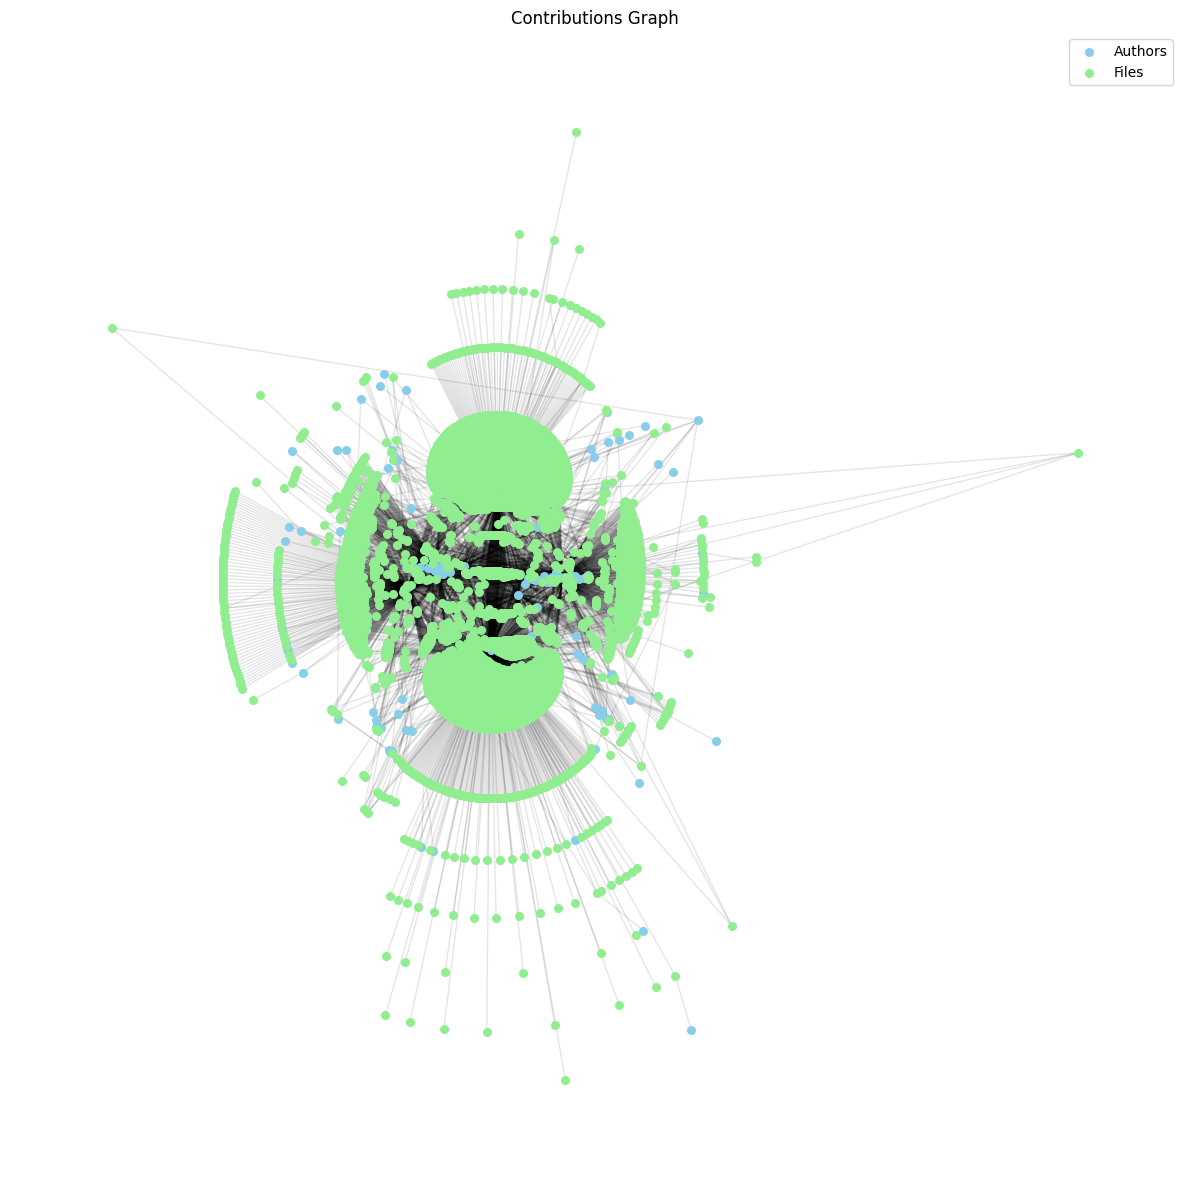

In [18]:
plot_graph(G)